In [2]:
import pandas as pd, numpy as np

In [14]:
# For laptop
klstVedurPath = 'D:\Skóli\lokaverkefni_vel\data\Vedurstofa\combined_klst.feather'
mergedPath = 'D:\Skóli\lokaverkefni_vel\data\merged-full-W-Landscape-And-Station-Elevations-25ms-24hr-11-3-24.feather'

In [4]:
# For PC
klstVedurPath = 'E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/combined_klst.feather'
mergedPath = 'E:/Skóli/HÍ/Vélaverkfræði Master Hí/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-2-sectors-25ms-24hr-18-3-24.feather'

In [ ]:
maelingaskra = 'D:/Skóli/lokaverkefni_vel/data/Vedurstofa/combined_klst.feather'
maelinga_df = pd.read_feather(maelingaskra)
maelinga_df = maelinga_df.drop(26953001, axis = 0)
maelinga_df.timi = pd.to_datetime(maelinga_df.timi)

In [20]:
df_10min = pd.read_feather(mergedPath)
df_10min.time = pd.to_datetime(df_10min.time)

In [21]:
# Rounds to next hour so as to be able to directly compare with the vedur klst file
def next_hour(time):
    return time.ceil('h')

df_10min['timi'] = df_10min.time.apply(next_hour)

In [30]:
maelinga_df.stod = maelinga_df.stod.astype(np.int64)
maelinga_df.fg = pd.to_numeric(maelinga_df.fg, errors = 'coerce', downcast='float')
maelinga_df.fx = pd.to_numeric(maelinga_df.fx, errors = 'coerce', downcast='float')

((30220136, 11),
 Index(['X', 'Y', 'time', 'ws_15', 'ws_250', 'ws_500', 'wd_15', 'wd_250',
        'wd_500', 'p_15', 'p_250', 'p_500', 't_15', 't_250', 't_500', 'stod',
        'f', 'fg', 'fsdev', 'd', 'dsdev', 'longitude', 'latitude', 'Ri_01',
        'Ri_12', 'Ri_02', 'N_01', 'N_12', 'N_02', 'station_elevation',
        'landscape_points', 'elevations'],
       dtype='object'))

In [31]:
sameinad_df = pd.merge(df_10min, maelinga_df, on = ['stod', 'timi'], how = 'inner', suffixes=('_10min', '_klst'))

sameinad_df

,X,Y,time,ws_15,ws_250,ws_500,wd_15,wd_250,wd_500,p_15,...,N_01,N_12,station_elevation,landscape_points,elevations,timi,f_klst,fx,fg_klst,d_klst
0,419760.4353,311410.4631,2020-02-14 09:40:00,19.6041,23.1354,23.5411,97.9485,99.3434,99.9549,98956.6580,...,-0.000134,-0.000003,33.438521,"[[420112.93989447743, 311361.54904540273], [42...","[779.7168035654618, 782.0526596557524, 786.179...",2020-02-14 10:00:00,23.6,27.500000,35.599998,78
1,419760.4353,311410.4631,2019-02-20 01:00:00,14.4611,16.8599,17.1642,145.3825,146.3173,146.5913,100351.7109,...,-0.000044,-0.000003,33.438521,"[[420112.4996219488, 311358.474764043], [42011...","[777.3745944169202, 782.0397823265109, 786.175...",2019-02-20 01:00:00,25.7,25.799999,34.200001,83
2,419760.4353,311410.4631,2019-02-17 00:40:00,8.5471,9.1812,9.1686,62.6103,65.3626,79.3139,100649.9705,...,-0.000009,0.000068,33.438521,"[[420116.31686465454, 311409.84196886426], [42...","[784.1650077215852, 788.0848430684046, 790.183...",2019-02-17 01:00:00,24.2,25.700001,34.299999,75
3,419760.4353,311410.4631,2019-02-05 23:40:00,10.3157,11.1665,11.1894,88.1111,89.3584,90.2917,101001.3064,...,-0.000038,0.000002,33.438521,"[[420114.5577725153, 311375.11697822495], [420...","[779.7686245550574, 784.150857915831, 786.2225...",2019-02-06 00:00:00,24,25.200001,33.299999,86
4,419760.4353,311410.4631,2018-12-17 19:30:00,11.2918,17.3783,17.6068,116.0218,129.5856,136.2121,99682.9219,...,0.000277,0.000205,33.438521,"[[420116.29789345217, 311406.73637940787], [42...","[784.1530257740433, 786.2250760674577, 790.170...",2018-12-17 20:00:00,23.6,27.700001,36.599998,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17955,543704.3472,672486.1026,2014-12-10 12:40:00,10.6554,11.5584,11.0643,6.4581,8.6411,12.4018,96755.1484,...,-0.000111,0.000016,19.654911,"[[543906.9435960962, 672778.6889533278], [5438...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2014-12-10 13:00:00,23.3,27.299999,35.500000,23
17956,543704.3472,672486.1026,2015-12-08 05:00:00,25.4698,31.2753,33.5225,97.3362,98.8644,101.6907,99002.3281,...,-0.000026,0.000087,19.654911,"[[544054.4942800443, 672422.4700910029], [5440...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2015-12-08 05:00:00,26.6,26.600000,33.400002,85
17957,543704.3472,672486.1026,2019-12-11 08:10:00,19.3720,22.8016,23.2493,41.1882,44.0706,46.2614,95774.5937,...,-0.000023,0.000041,19.654911,"[[543800.6490567861, 672828.7073668151], [5437...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2019-12-11 09:00:00,22.1,25.900000,33.200001,359
17958,543704.3472,672486.1026,2020-02-14 14:10:00,23.5278,28.6951,29.9320,93.5311,95.0293,96.2047,97827.6385,...,-0.000128,0.000027,19.654911,"[[544055.1414271548, 672426.1402446448], [5440...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2020-02-14 15:00:00,23.3,25.000000,35.799999,81


In [47]:
sameinad_df.iloc[4]

X                                                          419760.4353
Y                                                          311410.4631
time                                               2018-12-17 19:30:00
ws_15                                                          11.2918
ws_250                                                         17.3783
ws_500                                                         17.6068
wd_15                                                         116.0218
wd_250                                                        129.5856
wd_500                                                        136.2121
p_15                                                        99682.9219
p_250                                                       96849.4688
p_500                                                        93917.332
t_15                                                          277.7801
t_250                                                         277.3303
t_500 

In [33]:
df_final = sameinad_df[abs(sameinad_df.f_10min - sameinad_df.fx) <= 1000]

df_final.shape

(17354, 35)

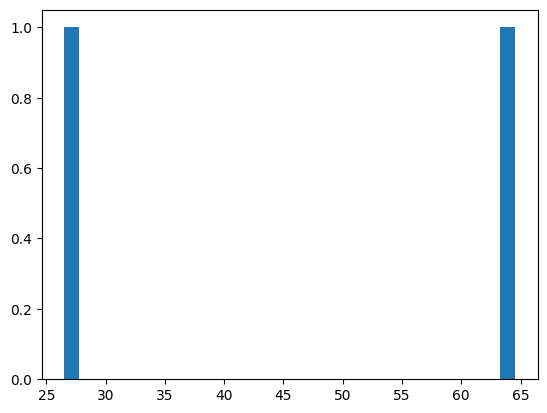

In [45]:
y = abs(sameinad_df.f_10min - sameinad_df.fx)

from matplotlib import pyplot as plt

plt.hist(y[y > 10], bins = 30)
plt.show()

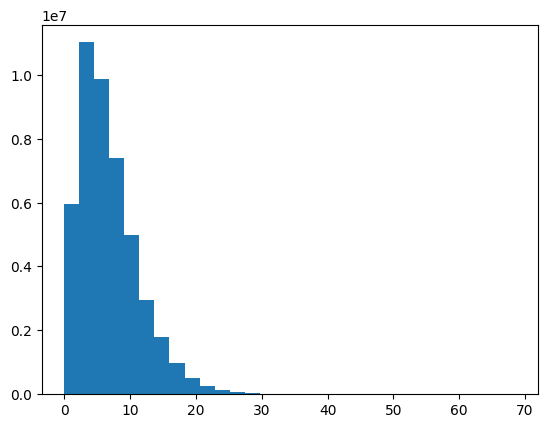

In [39]:
plt.hist(maelinga_df.fx, bins = 30)
plt.show()

In [42]:
sum(maelinga_df.fx.isna())

536165

In [44]:
sum(maelinga_df.fx > 20)

45841587

In [43]:
maelinga_df.shape

(46476897, 6)

In [37]:
N = df_10min.N_12
Ri = df_10min.Ri_12

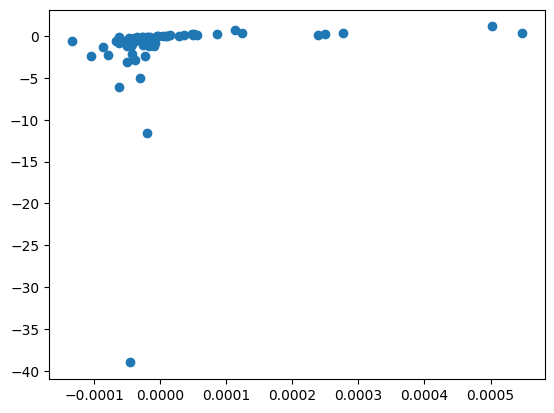

In [25]:
from matplotlib import pyplot as plt

plt.scatter(df_10min.N_01[:60], df_10min.Ri_01[:60])

plt.show()

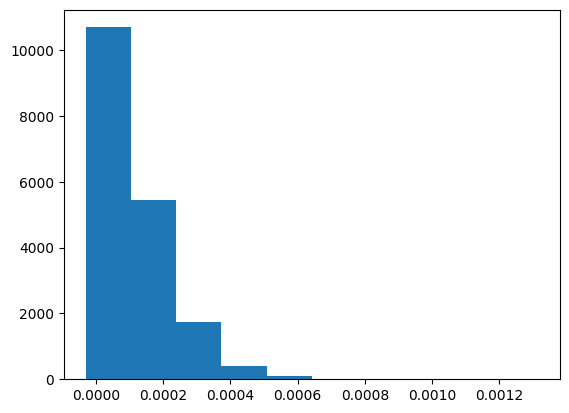

In [38]:
plt.hist(N)
plt.show()

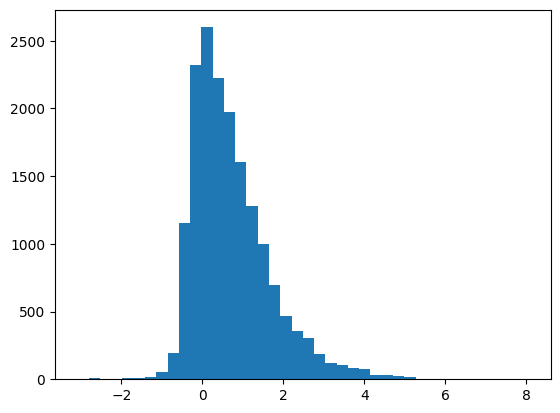

In [44]:
plt.hist(np.log10(Ri), bins = 40)
plt.show()

d:\Skóli\lokaverkefni_vel\code\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


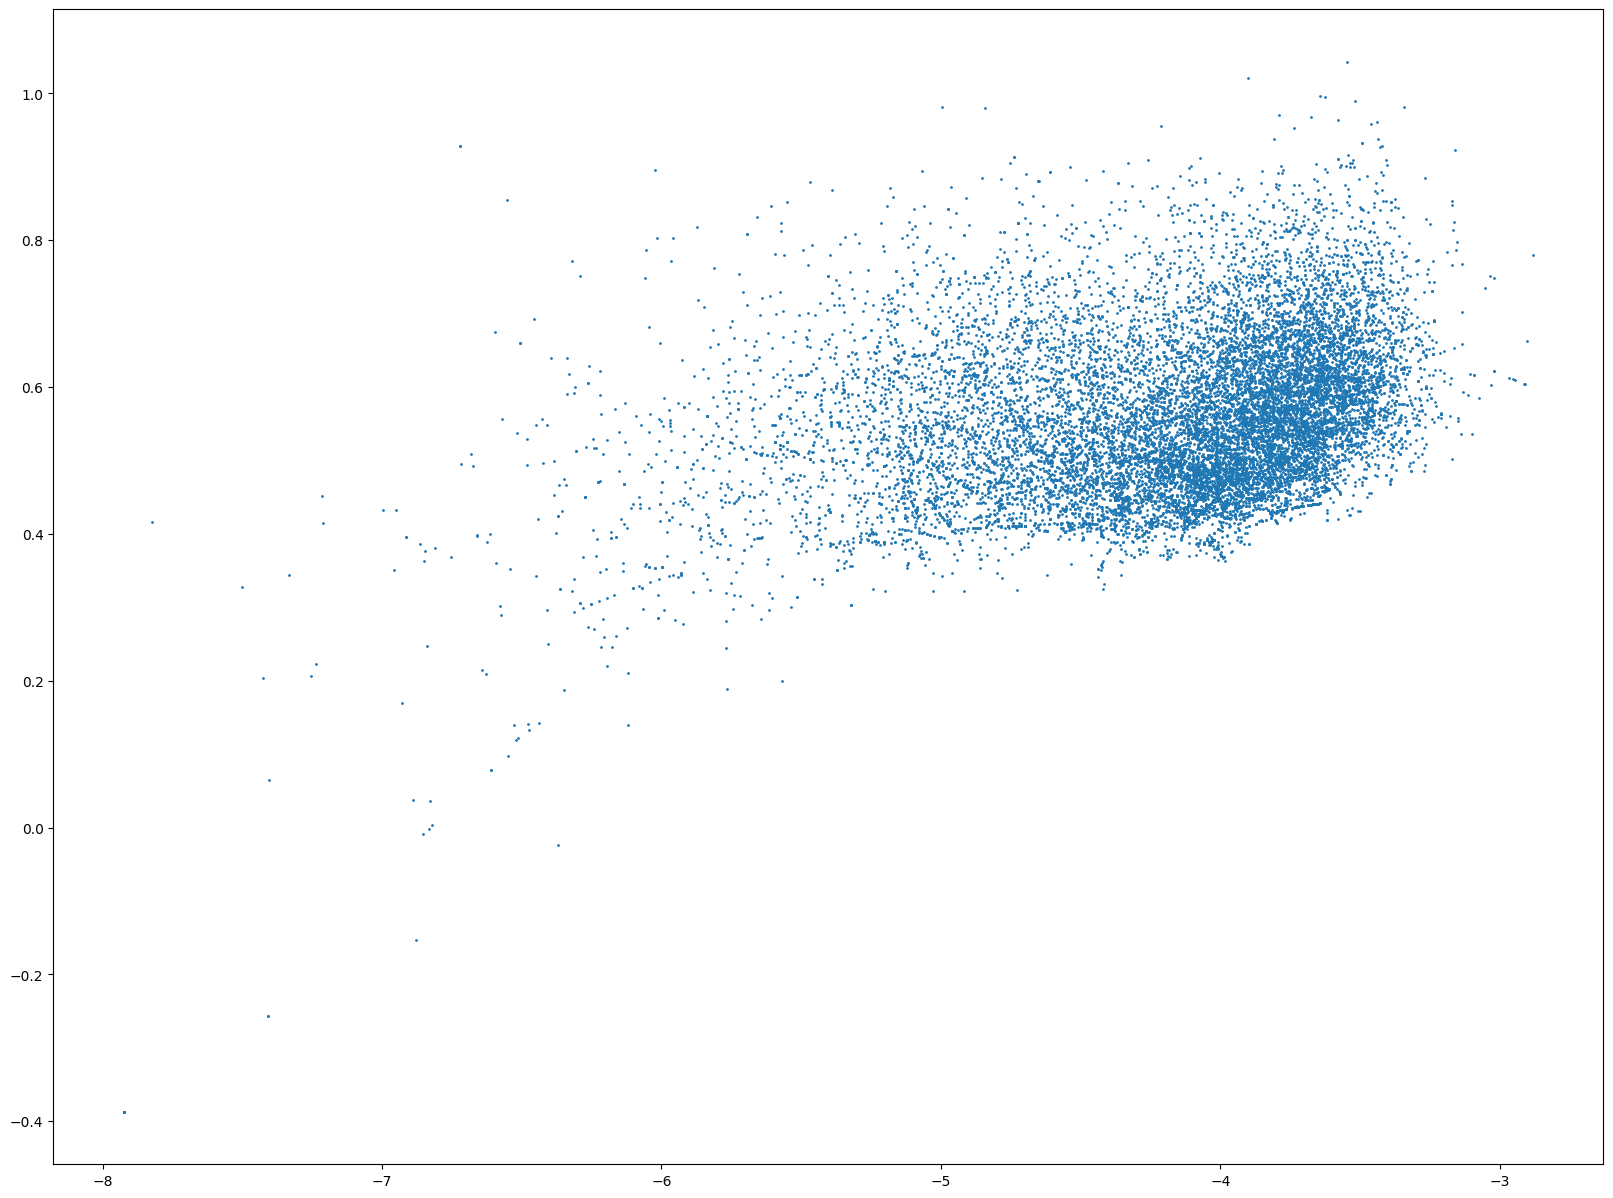

In [63]:
plt.figure(figsize=[20, 15])
plt.scatter(np.log10(N), np.log10(3+np.log10(Ri)), s = 1)
plt.show()

In [61]:
import statsmodels.api as sm

X = sm.add_constant(N.values.ravel())
y = np.log10(abs(Ri))

results = sm.OLS(y,X).fit()
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Ri_12   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1053.
Date:                Wed, 20 Mar 2024   Prob (F-statistic):          9.60e-225
Time:                        15:58:57   Log-Likelihood:                -25696.
No. Observations:               18431   AIC:                         5.140e+04
Df Residuals:                   18429   BIC:                         5.141e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5066      0.010     50.353      0.000       0.487       0.526
x1          2046.2287     63.050     32.454      0.000    1922.646    2169.812
==============================================================================
Omnibus:                     4986.685   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14452.510
Skew:                           1.418   Prob(JB):                         0.00
Kurtosis:                       6.282   Cond. No.                     8.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
len(df_10min)

18431

In [16]:
df_klst = df_klst.drop(index = 26952999)

df_klst = df_klst.sort_values(by=['timi'])

#df_vedur_klst.to_feather()

,timi,stod,f,fx,fg,d,dsdev,longitude,latitude,X,Y
25735444,1990-02-19 07:00:00,6300,5.3,7.0,8.3,45.0,14.1,-20.9707,63.9355,403355.367828,382834.566367
25735445,1990-02-19 08:00:00,6300,5.9,5.9,8.0,46.0,10.4,-20.9707,63.9355,403355.367828,382834.566367
25735446,1990-02-19 09:00:00,6300,3.1,6.9,10.0,49.0,14.3,-20.9707,63.9355,403355.367828,382834.566367
25735447,1990-02-19 10:00:00,6300,6.4,6.4,8.7,35.0,9.7,-20.9707,63.9355,403355.367828,382834.566367
25735448,1990-02-19 11:00:00,6300,6.2,7.1,10.3,41.0,13.1,-20.9707,63.9355,403355.367828,382834.566367
...,...,...,...,...,...,...,...,...,...,...,...
25773064,2023-10-05 09:00:00,6300,4.7,4.7,7.7,53.0,15.9,-20.9707,63.9355,403355.367828,382834.566367
29830795,2023-10-05 09:00:00,7001,9.4,9.4,11.7,60.0,NaN,-22.2496,63.9207,340596.727199,383775.944895
19674959,2023-10-05 09:00:00,4921,4.5,4.5,6.1,91.0,7.6,-16.1441,66.5114,627060.220015,671402.647156
14687304,2023-10-05 09:00:00,3696,1.0,1.0,2.3,1.0,19.1,-17.3281,66.0418,575785.171221,617159.740022


In [17]:
df_klst.timi = pd.to_datetime(df_klst.timi)
df_10min.time = pd.to_datetime(df_10min.time)

In [18]:
# Rounds to next hour so as to be able to directly compare with the vedur klst file
def next_hour(time):
    return time.ceil('h')

df_10min['timi'] = df_10min.time.apply(next_hour)

In [20]:
df_klst.stod = df_klst.stod.astype(np.int64)
df_klst.fg = pd.to_numeric(df_klst.fg, errors = 'coerce', downcast='float')

In [21]:
df_10min = pd.merge(df_10min, df_klst, on = ['stod', 'timi'], how = 'inner', suffixes=('_10min', '_klst'))

df_10min.shape

In [14]:
df_final = df_10min[abs(df_10min.f_merged - df_merged.fx) <= .1]

df_final.shape

(10365, 42)

In [15]:
df_final.columns

Index(['X_merged', 'Y_merged', 'time', 'ws_15', 'ws_250', 'ws_500', 'wd_15',
       'wd_250', 'wd_500', 'p_15', 'p_250', 'p_500', 't_15', 't_250', 't_500',
       'stod', 'f_merged', 'fg_merged', 'fsdev', 'd_merged', 'dsdev_merged',
       'longitude_merged', 'latitude_merged', 'Ri_01', 'Ri_12', 'Ri_02',
       'N_01', 'N_12', 'N_02', 'station_elevation', 'landscape_points',
       'elevations', 'timi', 'f_vedur', 'fx', 'fg_vedur', 'd_vedur',
       'dsdev_vedur', 'longitude_vedur', 'latitude_vedur', 'X_vedur',
       'Y_vedur'],
      dtype='object')

In [16]:
df_toWrite = df_final[['X_merged', 'Y_merged', 'time', 'ws_15', 'ws_250', 'ws_500', 'wd_15',
       'wd_250', 'wd_500', 'p_15', 'p_250', 'p_500', 't_15', 't_250', 't_500',
       'stod', 'f_merged', 'fg_10min', 'd_merged', 'longitude_10min', 'latitude_10min', 'Ri_01', 'Ri_12', 'N_01', 'N_12',
       'station_elevation', 'landscape_points', 'elevations']]

df_toWrite.columns

Index(['X_merged', 'Y_merged', 'time', 'ws_15', 'ws_250', 'ws_500', 'wd_15',
       'wd_250', 'wd_500', 'p_15', 'p_250', 'p_500', 't_15', 't_250', 't_500',
       'stod', 'f_merged', 'fg_merged', 'd_merged', 'longitude_merged',
       'latitude_merged', 'Ri_01', 'Ri_12', 'Ri_02', 'N_01', 'N_12', 'N_02',
       'station_elevation', 'landscape_points', 'elevations'],
      dtype='object')

In [17]:
df_toWrite = df_toWrite.rename({'X_10min':'X', 'Y_10min':'Y', 'f_10min':'f', 'fg_10min':'fg', 'd_10min':'d', 'longitude_10min':'longitude', 'latitude_10min':'latitude'}, axis = 1)

df_toWrite.columns

Index(['X', 'Y', 'time', 'ws_15', 'ws_250', 'ws_500', 'wd_15', 'wd_250',
       'wd_500', 'p_15', 'p_250', 'p_500', 't_15', 't_250', 't_500', 'stod',
       'f', 'fg', 'd', 'longitude', 'latitude', 'Ri_01', 'Ri_12', 'Ri_02',
       'N_01', 'N_12', 'N_02', 'station_elevation', 'landscape_points',
       'elevations'],
      dtype='object')

In [18]:
df_toWrite.to_feather('E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-2-sectors-25ms-24hr-18-3-24-stripped-with-klst.feather')